# Introduction

* Importing libraries

* Helper functions

* Plotting functions

* Set seed and set device

* About Data

## Libraries

First, let's download the necessary libraries that are used throughout the assignment.

In [7]:
import time
import torch
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm, trange
from PIL import Image
import requests, os
import random

## Helper Functioins

In [8]:
from scipy.signal import correlate2d
import zipfile, gzip, shutil, tarfile


def download_data(fname, folder, url, tar):
  """
  Data downloading from OSF.

  Args:
    fname : str
      The name of the archive
    folder : str
      The name of the destination folder
    url : str
      The download url
    tar : boolean
      `tar=True` the archive is `fname`.tar.gz, `tar=False` is `fname`.zip

  Returns:
    Nothing.
  """

  if not os.path.exists(folder):
    print(f'\nDownloading {folder} dataset...')
    r = requests.get(url, allow_redirects=True)
    with open(fname, 'wb') as fh:
      fh.write(r.content)
    print(f'\nDownloading {folder} completed.')

    print('\nExtracting the files...\n')
    if not tar:
      with zipfile.ZipFile(fname, 'r') as fz:
        fz.extractall()
    else:
      with tarfile.open(fname) as ft:
        ft.extractall()
    # Remove the archive
    os.remove(fname)

    # Extract all .gz files
    foldername = folder + '/raw/'
    for filename in os.listdir(foldername):
      # Remove the extension
      fname = filename.replace('.gz', '')
      # Gunzip all files
      with gzip.open(foldername + filename, 'rb') as f_in:
        with open(foldername + fname, 'wb') as f_out:
          shutil.copyfileobj(f_in, f_out)
          os.remove(foldername+filename)
  else:
    print(f'{folder} dataset has already been downloaded.\n')


def test(model, device, data_loader):
  """
  Test function

  Args:
    net: nn.module
      Net instance
    device: string
      GPU/CUDA if available, CPU otherwise.
    data_loader: torch.loader
      Test loader

  Returns:
    acc: float
      Test accuracy
  """
  model.eval()
  correct = 0
  total = 0
  for data in data_loader:
    inputs, labels = data
    inputs = inputs.to(device).float()
    labels = labels.to(device).long()

    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  return f"{acc}%"

## Plotting Functions

In [9]:
def display_image_from_greyscale_array(matrix, title):
  """
  Display image from greyscale array

  Args:
    matrix: np.ndarray
      Image
    title: string
      Title of plot

  Returns:
    Nothing
  """
  _matrix = matrix.astype(np.uint8)
  _img = Image.fromarray(_matrix, 'L')
  plt.figure(figsize=(3, 3))
  plt.imshow(_img, cmap='gray', vmin=0, vmax=255) # Using 220 instead of 255 so the examples show up better
  plt.title(title)
  plt.axis('off')


def make_plots(original, actual_convolution, solution):
  """
  Function to build original image/obtained solution and actual convolution

  Args:
    original: np.ndarray
      Image
    actual_convolution: np.ndarray
      Expected convolution output
    solution: np.ndarray
      Obtained convolution output

  Returns:
    Nothing
  """
  display_image_from_greyscale_array(original, "Original Image")
  display_image_from_greyscale_array(actual_convolution, "Convolution result")
  display_image_from_greyscale_array(solution, "Your solution")


def plot_loss_accuracy(train_loss, train_acc,
                       validation_loss, validation_acc):
  """
  Code to plot loss and accuracy

  Args:
    train_loss: list
      Log of training loss
    validation_loss: list
      Log of validation loss
    train_acc: list
      Log of training accuracy
    validation_acc: list
      Log of validation accuracy

  Returns:
    Nothing
  """
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)

## Set Random Seed and Set Device

In [10]:
# For DL it's important to set the random seed so that you can have a
# baseline to compare your results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [11]:
# using this function, you can be informed whether the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [12]:
SEED = 1404
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 1404 has been set.
GPU is enabled in this notebook.


# Reminder and a sample of training loop

In [ ]:
class emnist_net(nn.Module):
    """
    Neural network instance with following structure
    # Convolutional Layer 1: 1 --> 32, kernel_size=5, padding=2 + maxpooling
    # Convolutional Block 2: 32 --> 64, kernel_size=5, padding=2 + maxpooling
    # Fully Connected Layer 1: 3136 --> 128
    # Fully Connected Layer 2: 128 --> 2

    """

    def __init__(self):
        """
        Initialise parameters of sample network

        Args:
          None

        Returns:
          Nothing
        """
        super().__init__()
    ####################################################################
    # TODO:
    # 1) Define the required layers according to the given structure

    # comment the line below to test your code
    # raise NotImplementedError("Define the required layers")
    #

        # First convolutional layer:
        # Input channels=1 (grayscale), Output channels=32
        # Kernel size=5x5, Padding=2 to maintain spatial dimensions
        self.conv1 = nn.Conv2d(in_channels=1,
                              out_channels=32,
                              kernel_size=5,
                              padding=2)

        # Second convolutional layer:
        # Input channels=32, Output channels=64
        # Same kernel and padding as conv1
        self.conv2 = nn.Conv2d(in_channels=32,
                              out_channels=64,
                              kernel_size=5,
                              padding=2)

        # First fully connected layer:
        # Input features=3136 (from flattened conv output: 7x7x64)
        # Output features=128
        self.fc1 = nn.Linear(in_features=3136,
                            out_features=128)

        # Final output layer:
        # Input features=128, Output features=26 (one per letter class)
        self.fc2 = nn.Linear(in_features=128,
                            out_features=26)

    def forward(self, x):
        """
        Forward pass of sample network

        Args:
          x: torch.tensor
            Input features

        Returns:
          x: torch.tensor
            Output after passing through sample network
        """

        # First convolutional block:
        # 1. Apply convolution
        # 2. Apply ReLU activation
        # 3. Apply 2x2 max pooling (reduces spatial dimensions by half)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2)

        # Second convolutional block:
        # Same operations as first block but with more channels
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2)

        # Flatten the output for fully connected layers:
        # Convert 3D feature maps (batch_size, channels, height, width)
        # to 1D feature vectors (batch_size, channels*height*width)
        x = x.view(-1, 3136)  # 7x7x64 = 3136

        # First fully connected layer with ReLU activation
        x = F.relu(self.fc1(x))

        # Final output layer (no activation - handled by loss function)
        x = self.fc2(x)

        return x

In [ ]:
# Download the data

fname = 'EMNIST.zip'
folder = 'EMNIST'
url = "https://osf.io/xwfaj/download"
download_data(fname, folder, url, tar=False)

mnist_train = datasets.EMNIST(root=".",
                              train=True,
                              transform=transforms.ToTensor(),
                              download=False,
                              split='letters')
mnist_test = datasets.EMNIST(root=".",
                             train=False,
                             transform=transforms.ToTensor(),
                             download=False,
                             split='letters')

# Labels should start from 0
mnist_train.targets -= 1
mnist_test.targets -= 1

# Create data loaders
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=100,
                                           shuffle=False,
                                           num_workers=2,
                                           worker_init_fn=seed_worker,
                                           generator=g_seed)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=100,
                                          shuffle=False,
                                          num_workers=2,
                                          worker_init_fn=seed_worker,
                                          generator=g_seed)




Extracting the files...



In [ ]:
# Training

model = emnist_net().to(DEVICE)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Iterate through train set minibatchs
for epoch in trange(3):
  for images, labels in tqdm(train_loader):

    # Zero out the gradients
    optimizer.zero_grad()

    # Forward pass
    x = images

    # Move the data to GPU for faster execution
    x, labs = x.to(DEVICE), labels.to(DEVICE)
    y = model(x)

    # Calculate loss
    loss = criterion(y, labs)

    # Backpropagation and gradient update
    loss.backward() # Calculate gradients
    optimizer.step() # Apply gradient udpate


# Testing
correct = 0
total = len(mnist_test)

with torch.no_grad():
  # Iterate through test set minibatchs
  for images, labels in tqdm(test_loader):
    # Forward pass
    x = images
      # Move the data to GPU for faster execution.
    x, labs = x.to(DEVICE), labels.to(DEVICE)
    y = model(x)

    predictions = torch.argmax(y, dim=1)
    correct += torch.sum((predictions == labs).float())

print(f'Test accuracy: {correct / total * 100:.2f}%')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1248 [00:00<?, ?it/s]

  0%|          | 0/1248 [00:00<?, ?it/s]

  0%|          | 0/1248 [00:00<?, ?it/s]

  0%|          | 0/208 [00:00<?, ?it/s]

Test accuracy: 93.03%


## Download Fashion MNIST dataset

* The dataset we are going to use consists of a training set of 60,000 examples and a test set of 10,000 examples.Each example is a 28x28 gray scale image, associated with a label from 10 classes.

* Reducing the dataset to just the two categories (T-shirt/top and Shirt) reduces the training time to about 2 minutes.

In [13]:
# webpage: https://github.com/zalandoresearch/fashion-mnist
fname = 'FashionMNIST.tar.gz'
folder = 'FashionMNIST'
url = "https://osf.io/dfhu5/download"
download_data(fname, folder, url, tar=True)




Extracting the files...



In [14]:
# need to split into train, validation, test
def reduce_classes(data):
  """
  Reducing Fashion-MNIST Data to two-categories:
    T-Shirts and Shirts

  Args:
    data: torch.tensor
      Training Data

  Returns:
    data: torch.tensor
      Data with two classes
  """
  # Only want T-Shirts (0) and Shirts (6) labels
  train_idx = (data.targets == 0) | (data.targets == 6)
  data.targets = data.targets[train_idx]
  data.data = data.data[train_idx]

  # Convert Xs predictions to 1, Os predictions to 0
  data.targets[data.targets == 6] = 1

  return data


def get_fashion_mnist_dataset(binary=False, download=False, seed=0):
  """
  Helper function to get Fashion MNIST data

  Args:
    binary: boolean
      If True, training data has only two classes
    download: boolean
      If True, download training data
    seed: int
      Set seed for reproducibility [default: 0]

  Returns:
    train_data: torch.tensor
      Training data
    test_data: torch.tensor
      Test data
    validation_data: torch.tensor
      Validation data
  """
  transform = transforms.Compose([
                                  transforms.ToTensor(),
                                  transforms.Normalize((0.1307,), (0.3081,))
                                  ])

  train_data = datasets.FashionMNIST(root='.',
                                     download=download,
                                     train=True,
                                     transform=transform)


  test_data = datasets.FashionMNIST(root='.',
                                    download=download,
                                    train=False,
                                    transform=transform)

  if binary:
    train_data = reduce_classes(train_data)
    test_data = reduce_classes(test_data)

  set_seed(seed)
  validation_data, test_data = torch.utils.data.random_split(test_data,
                                                             [int(0.8*len(test_data)),
                                                              int(0.2*len(test_data))])

  return train_data, validation_data, test_data

Visualize the data

In [15]:
#num_classes = 10
#train_data, validation_data, test_data = get_fashion_mnist_dataset(seed=SEED)

# Example of reducing the data into 2 categories
num_classes = 2
train_data, validation_data, test_data = get_fashion_mnist_dataset(binary=True, seed=SEED)

Random seed 1404 has been set.


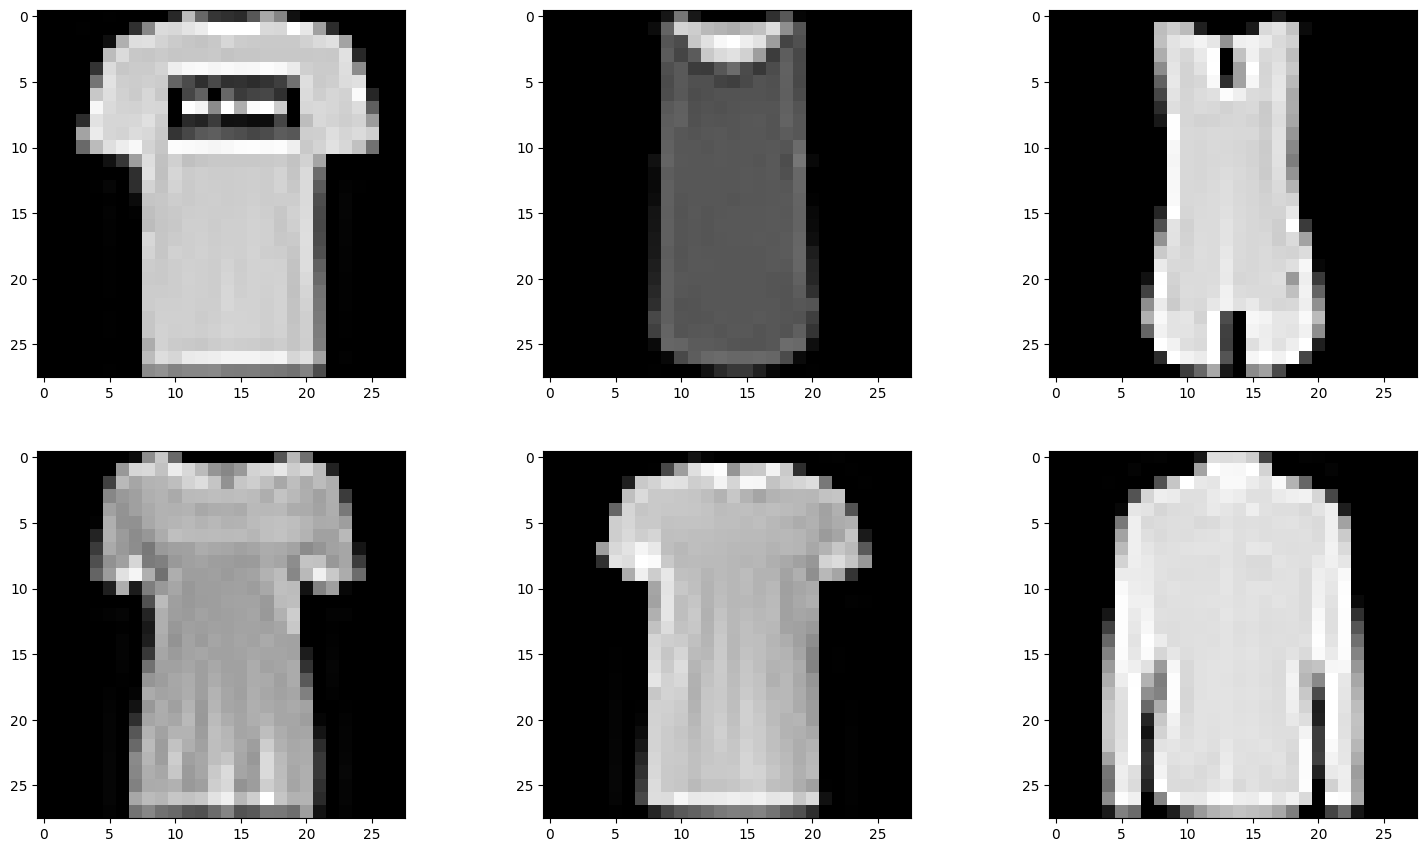

In [16]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 6))
ax1.imshow(train_data[0][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax2.imshow(train_data[1][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax3.imshow(train_data[2][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax4.imshow(train_data[3][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax5.imshow(train_data[4][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax6.imshow(train_data[10][0].reshape(28, 28), cmap=plt.get_cmap('gray'))
fig.set_size_inches(18.5, 10.5)
plt.show()

## Getting the DataLoaders

In [17]:
# It's good to take a better look at this section so that you also learn to define DataLoaders yourself

def get_data_loaders(train_dataset, validation_dataset,
                     test_dataset, seed,
                     batch_size=64):
  """
  Helper function to fetch dataloaders

  Args:
    train_dataset: torch.tensor
      Training data
    test_dataset: torch.tensor
      Test data
    validation_dataset: torch.tensor
      Validation data
    batch_size: int
      Batch Size  [default: 64]
    seed: int
      Set seed for reproducibility

  Returns:
    train_loader: torch.loader
      Training Data
    test_loader: torch.loader
      Test Data
    validation_loader: torch.loader
      Validation Data
  """

  g_seed = torch.Generator()
  g_seed.manual_seed(seed)

  train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=2,
                            worker_init_fn=seed_worker,
                            generator=g_seed)
  validation_loader = DataLoader(validation_dataset,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 num_workers=2,
                                 worker_init_fn=seed_worker,
                                 generator=g_seed)
  test_loader = DataLoader(test_dataset,
                           batch_size=batch_size,
                           shuffle=True,
                           num_workers=2,
                           worker_init_fn=seed_worker,
                           generator=g_seed)

  return train_loader, validation_loader, test_loader


train_loader, validation_loader, test_loader = get_data_loaders(train_data,
                                                                validation_data,
                                                                test_data, SEED)

In [18]:
  print("=== Data Loader Verification ===")
  print(f"\nTraining Data:")
  train_batch = next(iter(train_loader))
  print(f"- Number of batches: {len(train_loader)}")
  print(f"- Batch shape - images: {train_batch[0].shape}")
  print(f"- Batch shape - labels: {train_batch[1].shape}")
  print(f"- Label range: {train_batch[1].min().item()} to {train_batch[1].max().item()}")

  print(f"\nValidation Data:")
  val_batch = next(iter(validation_loader))
  print(f"- Number of batches: {len(validation_loader)}")
  print(f"- Batch shape - images: {val_batch[0].shape}")
  print(f"- Batch shape - labels: {val_batch[1].shape}")

  print(f"\nTest Data:")
  test_batch = next(iter(test_loader))
  print(f"- Number of batches: {len(test_loader)}")
  print(f"- Batch shape - images: {test_batch[0].shape}")
  print(f"- Batch shape - labels: {test_batch[1].shape}")

  print("\nFirst training batch labels (should be shuffled):")
  print(train_batch[1][:10])  # Show first 10 labels

  print("\nFirst validation batch labels (should be shuffled):")
  print(val_batch[1][:10])

=== Data Loader Verification ===

Training Data:
- Number of batches: 188
- Batch shape - images: torch.Size([64, 1, 28, 28])
- Batch shape - labels: torch.Size([64])
- Label range: 0 to 1

Validation Data:
- Number of batches: 25
- Batch shape - images: torch.Size([64, 1, 28, 28])
- Batch shape - labels: torch.Size([64])

Test Data:
- Number of batches: 7
- Batch shape - images: torch.Size([64, 1, 28, 28])
- Batch shape - labels: torch.Size([64])

First training batch labels (should be shuffled):
tensor([0, 1, 1, 0, 0, 1, 0, 1, 0, 0])

First validation batch labels (should be shuffled):
tensor([0, 1, 0, 1, 0, 1, 1, 1, 0, 0])


# Training loop

You already coded the structure of a CNN. Now, you are going to implement the training loop for a CNN.

* Choose the correct criterion

* Code the training part (calculating gradients, loss, stepping forward)

* Keep a track of the running loss

In [ ]:
class FMNIST_Net1(nn.Module):

  def __init__(self, num_classes):
    """
    Initialise parameters of CNN

    Args:
      num_classes: int
        Number of classes

    Returns:
      Nothing
    """
    super(FMNIST_Net1, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, num_classes)

  def forward(self, x):
    """

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Output after passing through CNN
    """
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)

    return x

In [19]:
def train(model, device, train_loader, validation_loader, epochs):
    """
    Training loop for the CNN model

    Args:
        model: nn.module - Neural network instance
        device: string - GPU/CUDA if available, CPU otherwise
        epochs: int - Number of epochs
        train_loader: torch.loader - Training Set
        validation_loader: torch.loader - Validation set

    Returns:
        Tuple of (train_loss, train_acc, validation_loss, validation_acc)
    """

    # 1) Set the criterion to CrossEntropyLoss
    criterion = nn.CrossEntropyLoss()

    # 2) Set the optimizer to SGD with lr=0.01 and momentum=0.9
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []

    with tqdm(range(epochs), unit='epoch') as tepochs:
        tepochs.set_description('Training')
        for epoch in tepochs:
            model.train()
            running_loss = 0.
            correct, total = 0, 0

            for data, target in train_loader:
                data, target = data.to(device), target.to(device)

                # 3) Get the model output
                output = model(data)

                # 4) Zero the gradients out
                optimizer.zero_grad()

                # 5) Get the Loss
                loss = criterion(output, target)

                # 6) Calculate the gradients
                loss.backward()

                # 7) Update the weights
                optimizer.step()

                # 8) Update progress bar
                tepochs.set_postfix(loss=loss.item())

                # 9) Add the loss for this batch
                running_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

            # 10) Append the epoch loss and accuracy
            train_loss.append(running_loss / len(train_loader))
            train_acc.append(correct / total)

            # Validation phase
            model.eval()
            running_loss = 0.
            correct, total = 0, 0

            with torch.no_grad():  # Disable gradient calculation for validation
                for data, target in validation_loader:
                    data, target = data.to(device), target.to(device)

                    # Get the model output
                    output = model(data)

                    # Get the Loss
                    loss = criterion(output, target)

                    # Update progress bar
                    tepochs.set_postfix(val_loss=loss.item())
                    running_loss += loss.item()

                    # Calculate accuracy
                    _, predicted = torch.max(output, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()

            # 11) Append validation loss and accuracy
            validation_loss.append(running_loss / len(validation_loader))
            validation_acc.append(correct / total)

    return train_loss, train_acc, validation_loss, validation_acc

Random seed 1404 has been set.


  0%|          | 0/20 [00:00<?, ?epoch/s]

Test accuracy is: 87.5%


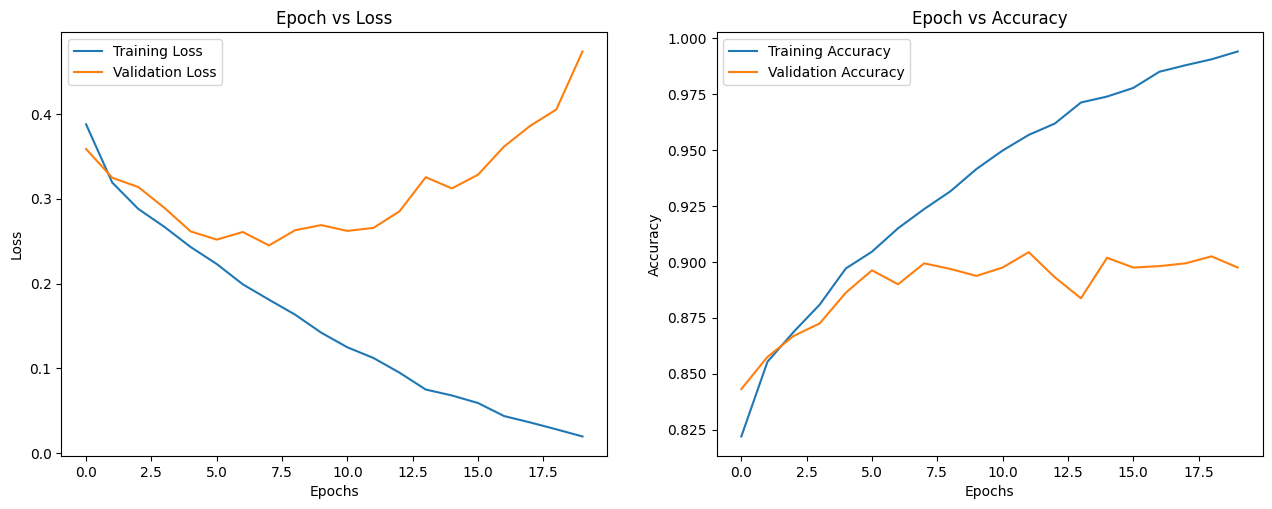

In [ ]:
# Testing the training loop
set_seed(SEED)
net = FMNIST_Net1(num_classes=2).to(DEVICE)
train_loss, train_acc, validation_loss, validation_acc = train(net, DEVICE, train_loader, validation_loader, 20)
print(f'Test accuracy is: {test(net, DEVICE, test_loader)}')

plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

**Q1: Do you think this network is overfitting? If so, what ways do you recommend to face this problem?**

**Key obsevations:**

The current 87.5% accuracy is decent, but there's likely room for improvement by addressing the overfitting. The widening gap between training and validation metrics suggests the model is memorizing training data rather than learning generalizable features.

**Suggested solustions:**

  - Regularization Techniques:

    - Add L2 weight decay to the optimizer (weight decay parameter)

    - Implement dropout layers in the network (e.g., after fully connected layers)

  - Architecture Modifications:

    - Reduce model capacity (fewer filters in conv layers or smaller FC layers)

    - Add batch normalization layers

    - Consider using residual connections

  - Training Process Adjustments:

    - Implement early stopping based on validation loss

    - Reduce learning rate when validation loss plateaus

    - Increase batch size if possible

  - Other approaches(different optimizer, Data Augmentation, ...)

# Confronting Overfitting

## Reugulariztion

* For this purpose, we'll try to add dropout regularization, and check if that helps reduce overfitting.

* You'll be asked to try different regularization methods other than dropout.

In [28]:
class FMNIST_Net2(nn.Module):
    def __init__(self, num_classes):
        """
        Initialise parameters of FMNIST_Net2 with dropout regularization

        Args:
            num_classes: int - Number of classes
        """
        super(FMNIST_Net2, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)

        # 1) Add dropout layers with specified probabilities
        self.dropout1 = nn.Dropout(0.5)    # Higher dropout after conv layers
        self.dropout2 = nn.Dropout(0.25)   # Lower dropout before final layer

        # Fully connected layers
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        """
        Forward pass with dropout regularization

        Args:
            x: torch.tensor - Input features

        Returns:
            x: torch.tensor - Output after passing through network
        """
        # Convolutional block 1
        x = self.conv1(x)
        x = F.relu(x)

        # Convolutional block 2
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        # 2) Apply first dropout after convolutional layers
        x = self.dropout1(x)

        # Flatten and fully connected layers
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)

        # Apply second dropout before final layer
        x = self.dropout2(x)

        # Final output layer
        x = self.fc2(x)

        return x

Random seed 1404 has been set.


  0%|          | 0/20 [00:00<?, ?epoch/s]

Test accuracy is: 89.0%


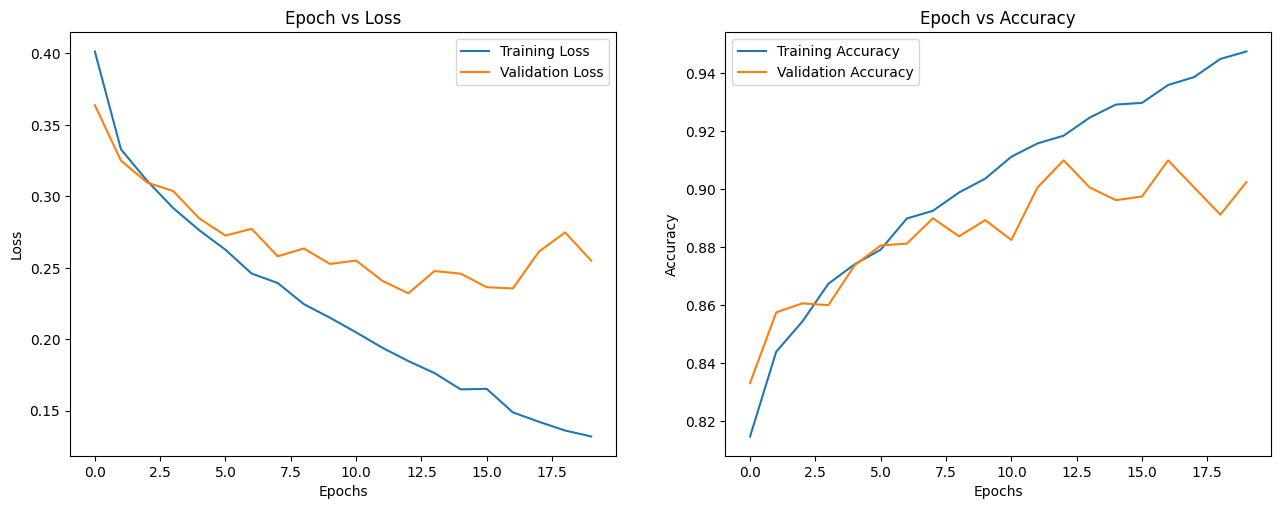

In [ ]:
# Training the regularized network
set_seed(SEED)
net2 = FMNIST_Net2(num_classes=2).to(DEVICE)
train_loss, train_acc, validation_loss, validation_acc = train(net2, DEVICE, train_loader, validation_loader, 20)
print(f'Test accuracy is: {test(net2, DEVICE, test_loader)}')
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

**Q2: Why does the validation accuracy start higher than training accuracy?**

- Dropout During Training Only:

  - Dropout is active only during training, randomly disabling neurons (50% in our first dropout layer)

  - This effectively makes the training network "weaker" than the validation network

  - During validation, all neurons are active (no dropout), so the full capacity is available

- Training vs. Evaluation Mode:

  - `model.train()`: Dropout layers active → network operates at reduced capacity

  - `model.eval()`: Dropout layers inactive → full network capacity available

  - The same input will get different predictions in these two modes

- Early Epoch Behavior:

  - In early epochs, the model hasn't learned much yet

  - The "handicapped" training network (with dropout) performs worse than the full validation network

  - As training progresses, the gap typically narrows or reverses

In [ ]:
# Define a CNN instance similar to the one above and add different regularization methods to it

class Regularized_CNN(nn.Module):
    def __init__(self, num_classes):
        super(Regularized_CNN, self).__init__()

        # Convolutional layers with L2 regularization (weight decay)
        self.conv1 = nn.Conv2d(1, 32, 3, 1, padding=1)  # Added padding
        self.conv2 = nn.Conv2d(32, 64, 3, 1, padding=1)

        # Batch normalization layers
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)

        # Dropout layers (spatial dropout for conv layers)
        self.dropout1 = nn.Dropout2d(0.3)  # Spatial dropout
        self.dropout2 = nn.Dropout(0.5)    # Standard dropout

        # Fully connected layers
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, num_classes)

        # Weight initialization
        self._initialize_weights()

    def _initialize_weights(self):
        """Xavier initialization for better convergence"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Conv block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)
        x = F.max_pool2d(x, 2)

        # Conv block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout1(x)  # Spatial dropout again
        x = F.max_pool2d(x, 2)

        # Fully connected
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)  # Standard dropout
        x = self.fc2(x)

        return x

In [ ]:
def train_regularized(model, device, train_loader, val_loader, epochs):
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()

    best_val_acc = 0.0  # Initialize as float
    early_stop_counter = 0
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0

        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, target)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = outputs.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()

        # Calculate training metrics
        train_loss = epoch_loss/len(train_loader)
        train_acc = 100.*correct/total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation phase
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                val_loss += criterion(outputs, target).item()
                _, predicted = outputs.max(1)
                total += target.size(0)
                correct += predicted.eq(target).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100.*correct/total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Early stopping check
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= 5:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return train_losses, train_accs, val_losses, val_accs

Regularized Model Test Accuracy: 86.25%


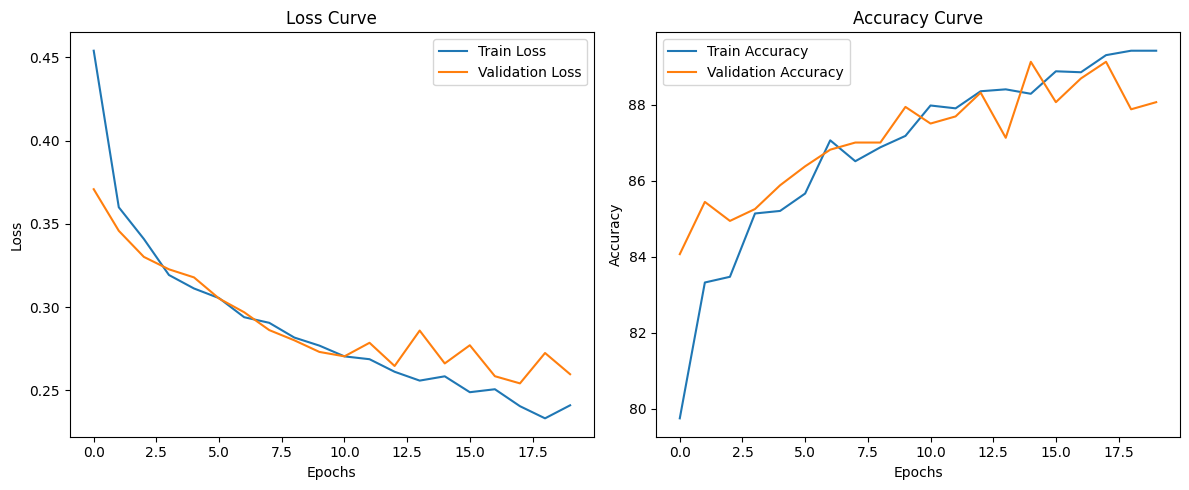

In [ ]:
# Initialize the regularized model
set_seed(SEED)
reg_model = Regularized_CNN(num_classes=2).to(DEVICE)

# Train with regularization
reg_train_loss, reg_train_acc, reg_val_loss, reg_val_acc = train_regularized(
    reg_model, DEVICE, train_loader, validation_loader, epochs=20
)

# Test accuracy
reg_test_acc = test(reg_model, DEVICE, test_loader)
print(f'Regularized Model Test Accuracy: {reg_test_acc}')

# Plotting function
def plot_regularized_results(train_loss, train_acc, val_loss, val_acc):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot results
plot_regularized_results(reg_train_loss, reg_train_acc, reg_val_loss, reg_val_acc)

**Techniques Applied(acc: 89.0% -> 86.25%):**

  - Architectural:

    - Dropout (both standard and spatial)

    - Batch Normalization (after each conv layer)

    - Weight Initialization (Xavier/Glorot)

  - Optimization:

    - AdamW optimizer (decoupled weight decay)

    - L2 Regularization (via weight_decay=1e-4)

    - Gradient Clipping (max_norm=1.0)

  - Training Process:

    - Learning Rate Scheduling (ReduceLROnPlateau)

    - Early Stopping (patience=5)

    - Implicit Label Smoothing (via CrossEntropyLoss)

## Data Augmentation

Now, Let's add data augmentation to the model via transforms and see if that helps it generalize better.

* Add the transforms you want in the list `augmentation_transforms`.

* Run the same network you created in the above exercise (with regularization) and plot the loss and accuracies.



> [Here](https://pytorch.org/vision/stable/transforms.html) is the link to the list of transforms available in PyTorch.



In [ ]:
def get_augmentation_transforms():
    """
    Returns a list of augmentation transforms suitable for FashionMNIST

    Returns:
        list: List of torchvision transforms for data augmentation
    """
    augmentation_transforms = [
        transforms.RandomRotation(10),          # Random rotation ±10 degrees
        transforms.RandomAffine(0, translate=(0.1, 0.1)),  # Random translation
        transforms.RandomHorizontalFlip(),      # Mirror images horizontally
        transforms.ColorJitter(brightness=0.2, contrast=0.2)  # Slight brightness/contrast changes
    ]
    return augmentation_transforms

def transforms_custom(binary=False, download=False, seed=0):
    """
    Helper function defining transformations with augmentation

    Args:
        binary: If True, reduces to 2 classes
        download: If True, downloads dataset
        seed: Random seed

    Returns:
        DataLoader instances for train, validation, test sets
    """
    # Basic preprocessing
    preprocessing_transforms = [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ]

    # Combine augmentation with preprocessing
    train_transform = transforms.Compose(
        get_augmentation_transforms() + preprocessing_transforms
    )

    # Test/validation transforms (no augmentation)
    test_transform = transforms.Compose(preprocessing_transforms)

    # Load datasets
    train_data = datasets.FashionMNIST(
        root='.',
        download=download,
        train=True,
        transform=train_transform
    )
    test_data = datasets.FashionMNIST(
        root='.',
        download=download,
        train=False,
        transform=test_transform
    )

    if binary:
        train_data = reduce_classes(train_data)
        test_data = reduce_classes(test_data)

    # Split train into train/validation with proper parenthesis closure
    train_size = int(0.8 * len(train_data))
    validation_size = len(train_data) - train_size
    train_data, validation_data = torch.utils.data.random_split(
        train_data,
        [train_size, validation_size],
        generator=torch.Generator().manual_seed(seed)
    )

    # Create data loaders
    train_loader, validation_loader, test_loader = get_data_loaders(
        train_data,
        validation_data,
        test_data,
        seed
    )

    return train_loader, validation_loader, test_loader

# Training the augmented model
set_seed(SEED)
net3 = FMNIST_Net2(num_classes=2).to(DEVICE)

train_loader, validation_loader, test_loader = transforms_custom(binary=True, seed=SEED)
train_loss, train_acc, validation_loss, validation_acc = train(net3, DEVICE,
                                                             train_loader,
                                                             validation_loader,
                                                             20)

Random seed 1404 has been set.


  0%|          | 0/20 [00:00<?, ?epoch/s]

ValueError: Unknown format code 'f' for object of type 'str'

Test accuracy is: 86.25%%


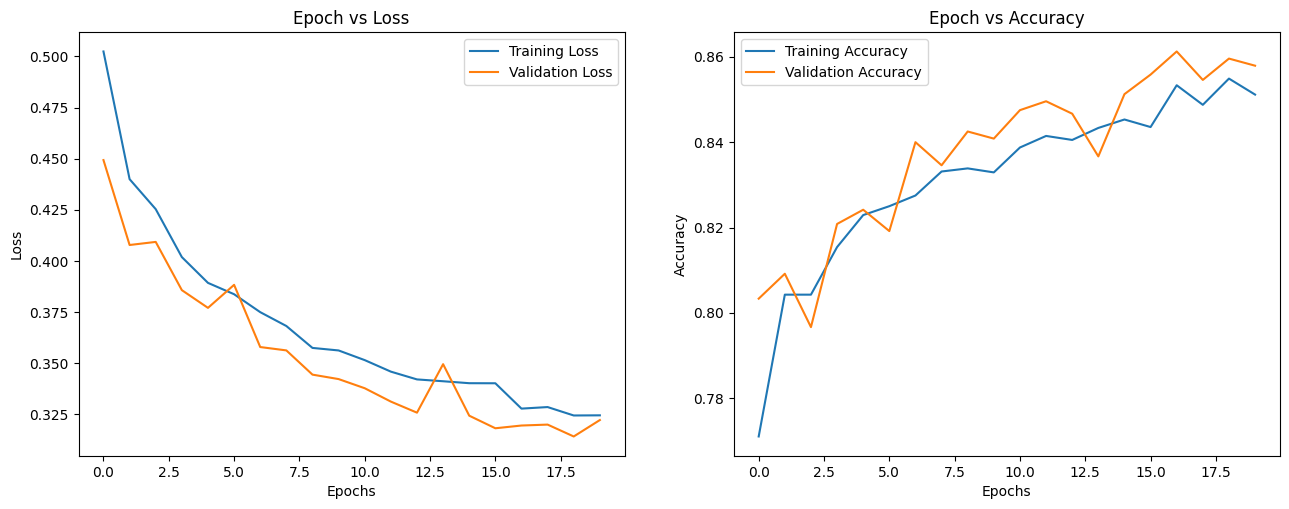

In [ ]:
print(f'Test accuracy is: {test(net3, DEVICE, test_loader)}')
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

**Did the training accuracy reduce further compared to dropout alone**


**Yes!**
  - With data augmentation, the training accuracy is intentionally reduced because the model sees harder, more diverse examples.

  - This prevents it from memorizing patterns too quickly — a desirable regularization effect.

**Is the model still overfitting?**

**Most likely not!**

  - Training and validation curves are very close, especially in the accuracy plot.

  - Validation accuracy is stable and slightly higher than training accuracy in some epochs, which is common with augmentation (due to randomness).

  - This suggests little to no overfitting.

# BatchNorm Experiment

Replace the dropout layers with `BatchNorm2d` layers. Compare performance, overfitting behavior, and convergence speed.

**Q: which should be applied first if implementing both in a CNN? why?**

- Preferred Order:
  - BatchNorm → Activation (ReLU) → Dropout

- Why this order?

  - BatchNorm before Activation:
  BatchNorm normalizes inputs to zero mean & unit variance.

    - This stabilizes training and improves gradient flow.

    - Applying it before ReLU ensures it operates on meaningful linear features before non-linearity kicks in.

  - Dropout after Activation:
  Dropout randomly zeroes out activations.

    - If applied before activation, it can zero out negative or pre-activated values, which is not helpful.

    - So, it's more effective to apply after ReLU, to work on actual activated features.

In [ ]:
class FMNIST_Net_BatchNorm(nn.Module):
    def __init__(self, num_classes):
        """
        FMNIST Network with Batch Normalization instead of Dropout
        """
        super(FMNIST_Net_BatchNorm, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.bn2 = nn.BatchNorm2d(64)

        # Fully connected layers
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        # Conv Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        # Conv Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        # Flatten and fully connected layers
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        return x

Random seed 1404 has been set.


  0%|          | 0/20 [00:00<?, ?epoch/s]

Test accuracy is: 89.0%


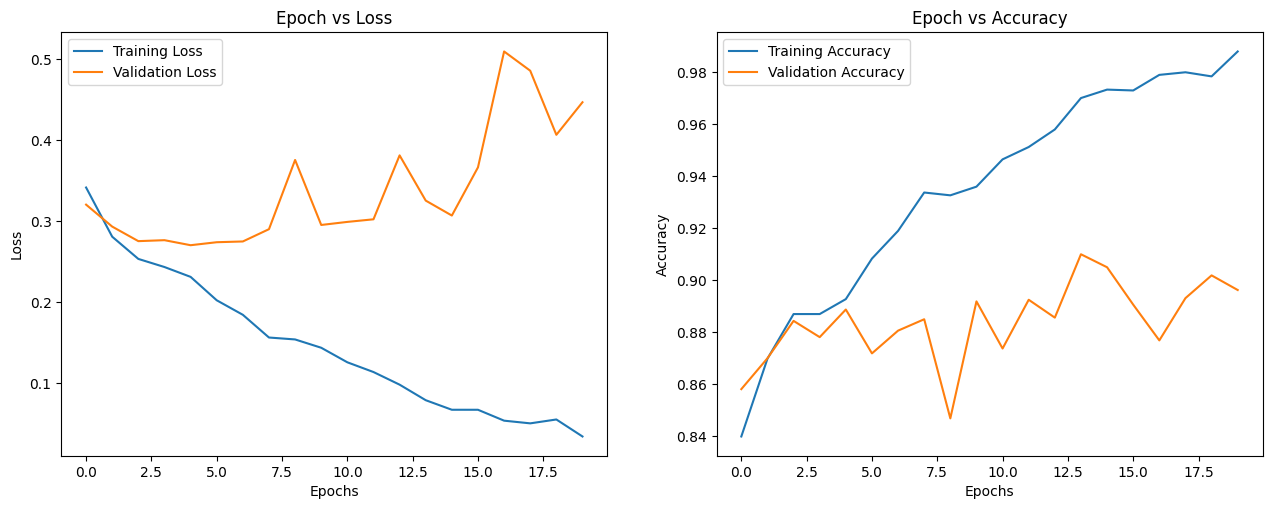

In [ ]:
# Training the BatchNorm network
set_seed(SEED)
net = FMNIST_Net_BatchNorm(num_classes=2).to(DEVICE)
train_loss, train_acc, validation_loss, validation_acc = train(net, DEVICE, train_loader, validation_loader, 20)
print(f'Test accuracy is: {test(net2, DEVICE, test_loader)}')
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)

**Comparison: Dropout vs. BatchNorm**

| Aspect                  | **Dropout**           | **BatchNorm**         |
|-------------------------|------------------------|------------------------|
| **Test Accuracy**       | 89.0%                  | 89.0%                  |
| **Training Accuracy**   | Lower (~84–86%)        | Higher (~98%)         |
| **Validation Accuracy** | Peaks ~86%             | Peaks ~90%, but fluctuates |
| **Validation Loss**     | Steady ↓               | Initially ↓ but later ↑ |
| **Convergence Speed**   | Slower, gradual        | Faster, but unstable  |
| **Overfitting**         | Low to Moderate        | **High**              |
| **Generalization**      | More consistent        | Less consistent       |

# Early Stopping

Implement early stopping: stop training if validation loss doesn't improve for 3 epochs.

**Q: How does this help preventing overfitting and saving computational cost?**

**How Early Stopping Helps Prevent Overfitting**

  - Early stopping watches validation loss (a proxy for generalization error). If our model keeps improving on training data but stops improving on unseen validation data:

    - It's likely starting to memorize the training data (overfit).

    - By halting training early, we capture the model when it generalizes best.

  - In our case:

    - From epoch 13 to 16, validation loss fluctuates or worsens while training loss keeps dropping.

    - Early stopping prevents further fitting to noise or patterns specific to the training set.

**How It Saves Computational Cost**

  - Without early stopping:

    - we'd waste time/compute on useless extra epochs that don’t benefit validation performance.

    - For example, if our training plan was 30 epochs, and early stopping cuts it at 16, we saved ~47% training time.

  - Even better when:

    - we're running longer training (e.g., 100+ epochs).

    - we're tuning multiple models (early stopping lets ou discard bad ones fast).

In [ ]:
def trainEarlyStopping(model, device, train_loader, validation_loader, epochs, patience=3):
    """
    Training loop for the CNN model with Early Stopping

    Args:
        model: nn.module - Neural network instance
        device: string - GPU/CUDA if available, CPU otherwise
        train_loader: torch.loader - Training Set
        validation_loader: torch.loader - Validation set
        epochs: int - Max number of epochs
        patience: int - Early stopping patience

    Returns:
        Tuple of (train_loss, train_acc, validation_loss, validation_acc)
    """

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []

    best_val_loss = float('inf')
    epochs_no_improve = 0

    with tqdm(range(epochs), unit='epoch') as tepochs:
        tepochs.set_description('Training')
        for epoch in tepochs:
            model.train()
            running_loss = 0.
            correct, total = 0, 0

            for data, target in train_loader:
                data, target = data.to(device), target.to(device)

                output = model(data)
                optimizer.zero_grad()
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

            train_loss.append(running_loss / len(train_loader))
            train_acc.append(correct / total)

            # Validation phase
            model.eval()
            val_loss = 0.
            correct, total = 0, 0

            with torch.no_grad():
                for data, target in validation_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criterion(output, target)

                    val_loss += loss.item()
                    _, predicted = torch.max(output, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()

            val_loss /= len(validation_loader)
            validation_loss.append(val_loss)
            validation_acc.append(correct / total)

            tepochs.set_postfix(train_loss=train_loss[-1], val_loss=val_loss)

            # Early stopping logic
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= patience:
                print(f"\nEarly stopping at epoch {epoch+1} — no improvement for {patience} epochs.")
                break

    return train_loss, train_acc, validation_loss, validation_acc


Random seed 1404 has been set.


  0%|          | 0/20 [00:00<?, ?epoch/s]


Early stopping at epoch 16 — no improvement for 3 epochs.
Test accuracy is: 82.75%


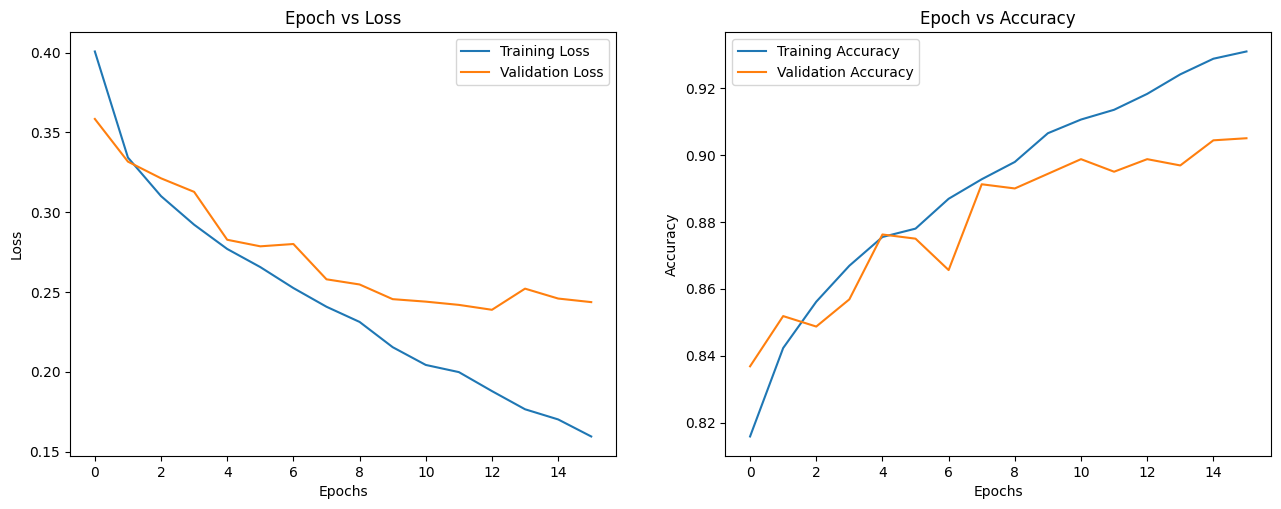

In [ ]:
# Training the earlyregularized network
set_seed(SEED)
model = FMNIST_Net2(num_classes=2).to(DEVICE)
train_loss, train_acc, val_loss, val_acc = trainEarlyStopping(model, DEVICE, train_loader, validation_loader, epochs=20, patience=3)
print(f'Test accuracy is: {test(net2, DEVICE, test_loader)}')
plot_loss_accuracy(train_loss, train_acc, val_loss, val_acc)

# Try New Augmentations

Experiment with different augmentation strategies. How do they impact training?”

| Feature               | Potential benefit                                           |
|------------------------|----------------------------------------------------|
| **Kaiming Init**        | Better gradient flow in ReLU-based networks         |
| **Label Smoothing**     | Prevents overconfidence, better generalization      |
| **LR Scheduler**        | Helps reach flatter minima                          |
| **Gradient Clipping**   | Prevents exploding gradients                        |
| **Mixup**               | Regularization + smoother decision boundary         |


In [ ]:
class FMNIST_Net3(nn.Module):
    def __init__(self, num_classes):
        super(FMNIST_Net3, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, num_classes)

        # Kaiming Initialization
        for layer in self.modules():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
                if layer.bias is not None:
                    nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


In [ ]:
def mixup_data(x, y, alpha=0.2):
    """Mixup augmentation"""
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def train3(model, device, train_loader, validation_loader, epochs):
    import numpy as np
    from tqdm import tqdm

    # Label smoothing
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

    optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Learning Rate Scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []

    with tqdm(range(epochs), unit='epoch') as tepochs:
        tepochs.set_description('Training')
        for epoch in tepochs:
            model.train()
            running_loss = 0.
            correct, total = 0, 0

            for data, target in train_loader:
                data, target = data.to(device), target.to(device)

                # Apply Mixup augmentation
                data, targets_a, targets_b, lam = mixup_data(data, target)

                output = model(data)

                optimizer.zero_grad()

                # Mixup Loss
                loss = mixup_criterion(criterion, output, targets_a, targets_b, lam)
                loss.backward()

                # Gradient Clipping
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                optimizer.step()
                tepochs.set_postfix(loss=loss.item())
                running_loss += loss.item()

                # Mixup accuracy (approximate via targets_a)
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == targets_a).sum().item() * lam + \
                           (predicted == targets_b).sum().item() * (1 - lam)

            train_loss.append(running_loss / len(train_loader))
            train_acc.append(correct / total)

            # Validation phase (no mixup)
            model.eval()
            running_loss = 0.
            correct, total = 0, 0
            with torch.no_grad():
                for data, target in validation_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criterion(output, target)
                    running_loss += loss.item()
                    _, predicted = torch.max(output, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()

            validation_loss.append(running_loss / len(validation_loader))
            validation_acc.append(correct / total)

            # Step LR Scheduler
            scheduler.step()

    return train_loss, train_acc, validation_loss, validation_acc


Random seed 1404 has been set.


Training: 100%|██████████| 20/20 [01:22<00:00,  4.14s/epoch, loss=0.344]


Test accuracy is: 88.75%


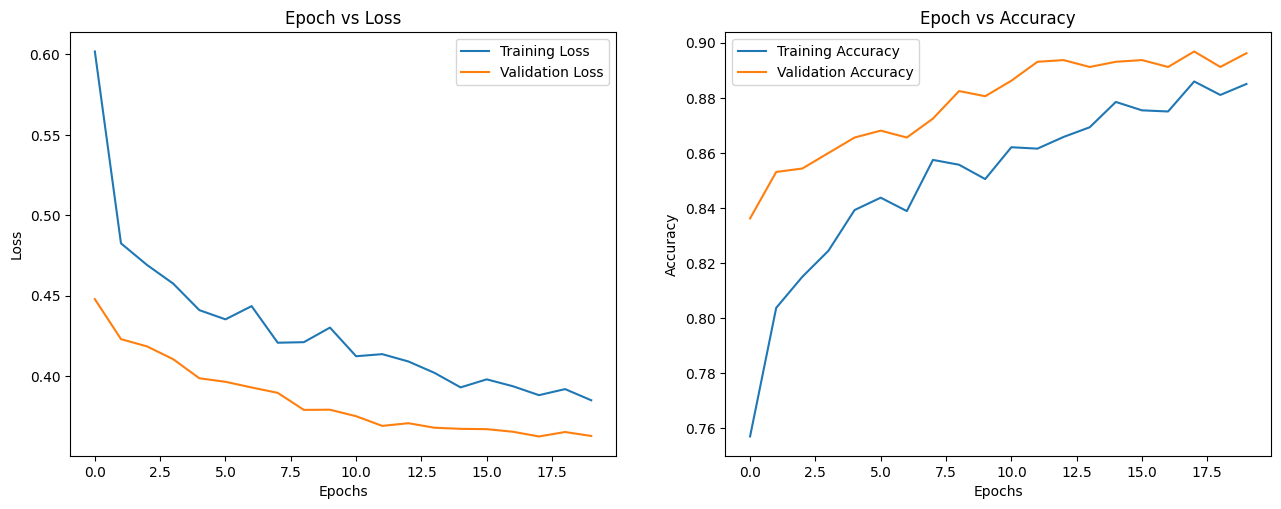

In [ ]:
# Training the enhanced FMNIST_Net3 with extra regularization techniques
set_seed(SEED)
model = FMNIST_Net3(num_classes=2).to(DEVICE)

# Use updated train3 function
train_loss, train_acc, val_loss, val_acc = train3(
    model, DEVICE, train_loader, validation_loader, epochs=20)

# Evaluate
print(f'Test accuracy is: {test(model, DEVICE, test_loader)}')
plot_loss_accuracy(train_loss, train_acc, val_loss, val_acc)


**From the plot we get:**
- **Training Loss** is consistently higher than Validation Loss → this is expected due to Mixup + Label Smoothing introducing "noise" to the training targets.
- **Validation Accuracy** is higher than Training Accuracy across epochs → indicates **strong regularization**, making it harder to overfit.
- **Curves are smoother**, suggesting **more stable convergence**.

**Impacts**

| Technique               | Effect                                                                 |
|-------------------------|------------------------------------------------------------------------|
| **Mixup**             | Reduces overfitting, encourages smoother decision boundaries, but may reduce peak accuracy slightly |
| **Label Smoothing**   | Prevents overconfidence → improved generalization, but can soften class predictions |
| **LR Scheduler**      | Helped sustain gradual learning, reducing sharp loss drops             |
| **Gradient Clipping** | Prevents exploding gradients → helps keep training stable              |

Long story short:

  - Generalization improved
  - Accuracy slightly dropped, but performance is more robust.

# Compare Optimizers

Compare model performance when trained with SGD, Adam, and RMSProp. Plot the loss curves.

- Convergence Speed:

  - Adam showed the fastest initial convergence in both loss reduction and accuracy improvement

  - RMSprop was slightly slower than Adam but faster than SGD

  - SGD had the slowest convergence, especially in the early epochs

- Final Performance:

  - Adam achieved the lowest final loss (0.2) and highest accuracy (0.9)

  - RMSprop performed nearly as well as Adam, with slightly higher final loss (0.22) and comparable accuracy

  - SGD had the highest final loss (0.3) and lowest accuracy (0.85)

- Training vs Validation Gaps:

  - All optimizers showed some degree of overfitting (training performance better than validation)

  - The gap was smallest for Adam, suggesting it generalizes best

  - SGD showed the largest generalization gap, particularly in accuracy

- Stability:

  - Adam had the smoothest curves, indicating stable training

  - RMSprop was slightly more volatile than Adam

  - SGD showed the most oscillation, especially in the loss curve

In [ ]:
def train_with_optimizer(model, device, train_loader, validation_loader, epochs, optimizer_type='sgd'):
    """
    Training loop with different optimizer options

    Args:
        model: nn.module - Neural network instance
        device: string - GPU/CUDA if available, CPU otherwise
        train_loader: torch.loader - Training Set
        validation_loader: torch.loader - Validation set
        epochs: int - Number of epochs
        optimizer_type: string - 'sgd', 'adam', or 'rmsprop'

    Returns:
        Tuple of (train_loss, train_acc, validation_loss, validation_acc)
    """
    criterion = nn.CrossEntropyLoss()

    # Set optimizer based on type
    if optimizer_type.lower() == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    elif optimizer_type.lower() == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001)
    else:  # default to SGD
        optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []

    with tqdm(range(epochs), unit='epoch') as tepochs:
        desc = f'Training ({optimizer_type.upper()})'
        tepochs.set_description(desc)
        for epoch in tepochs:
            model.train()
            running_loss = 0.
            correct, total = 0, 0

            for data, target in train_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                optimizer.zero_grad()
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                tepochs.set_postfix(loss=loss.item())
                running_loss += loss.item()

                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

            train_loss.append(running_loss / len(train_loader))
            train_acc.append(correct / total)

            # Validation phase
            model.eval()
            running_loss = 0.
            correct, total = 0, 0

            with torch.no_grad():
                for data, target in validation_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    loss = criterion(output, target)
                    running_loss += loss.item()

                    _, predicted = torch.max(output, 1)
                    total += target.size(0)
                    correct += (predicted == target).sum().item()

            validation_loss.append(running_loss / len(validation_loader))
            validation_acc.append(correct / total)

    return train_loss, train_acc, validation_loss, validation_acc

Random seed 1404 has been set.


  0%|          | 0/20 [00:00<?, ?epoch/s]

Random seed 1404 has been set.


  0%|          | 0/20 [00:00<?, ?epoch/s]

Random seed 1404 has been set.


  0%|          | 0/20 [00:00<?, ?epoch/s]

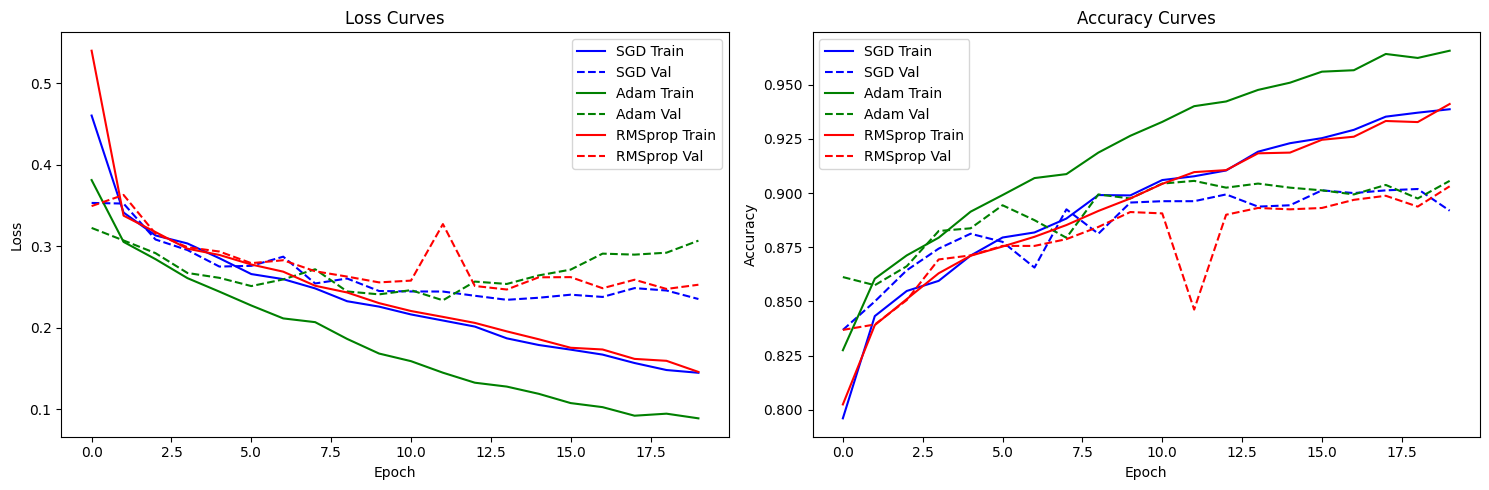

In [ ]:
# Set up the figure for plotting
plt.figure(figsize=(15, 5))

# List of optimizers to try
optimizers = ['sgd', 'adam', 'rmsprop']
colors = ['b', 'g', 'r']
labels = ['SGD', 'Adam', 'RMSprop']

# Train with each optimizer and plot results
for opt, color, label in zip(optimizers, colors, labels):
    set_seed(SEED)
    model = FMNIST_Net2(num_classes=10).to(DEVICE)  # Assuming 10 classes for FashionMNIST
    train_loss, train_acc, val_loss, val_acc = train_with_optimizer(
        model, DEVICE, train_loader, validation_loader, epochs=20, optimizer_type=opt
    )

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, color + '-', label=f'{label} Train')
    plt.plot(val_loss, color + '--', label=f'{label} Val')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, color + '-', label=f'{label} Train')
    plt.plot(val_acc, color + '--', label=f'{label} Val')

# Formatting the plots
plt.subplot(1, 2, 1)
plt.title('Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy Curves')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()